# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [3]:
import torch
from torchvision import datasets, transforms

In [5]:
x = datasets.MNIST('data', download=True)
x[0]

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11008735.41it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 5589502.30it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 18490600.54it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5874353.61it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(<PIL.Image.Image image mode=L size=28x28>, 5)

In [6]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [7]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [8]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [9]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

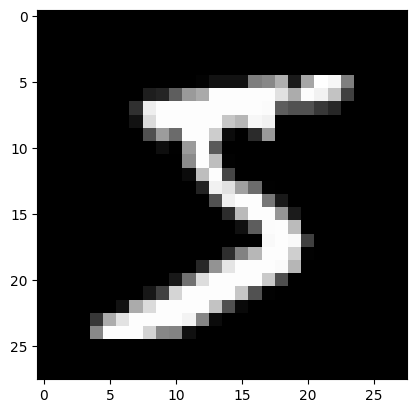

In [10]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

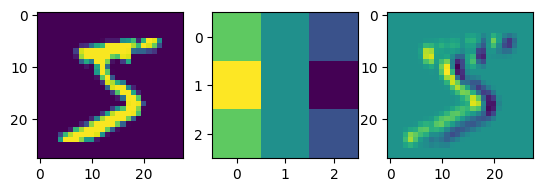

In [11]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [15]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/qb24/lib/python3.12/site-packages/torch/nn/functional.py:1354: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_26964/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [16]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

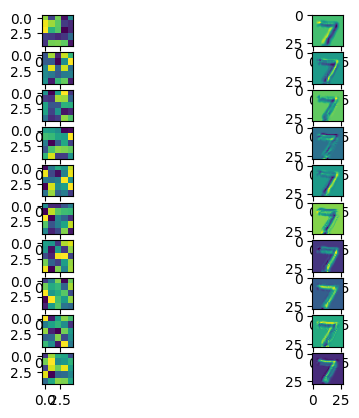

In [17]:
visualize()

# Predict Using Network

In [18]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [19]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_26964/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 5, 4, 2, 8])

# First Test and Train

In [20]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [21]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_26964/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 9%



In [22]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [23]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_26964/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.330237
Train loss: 1.958324
Train loss: 1.106326
Train loss: 1.031665
Train loss: 0.598656
Train loss: 0.746987
Train loss: 0.525990
Train loss: 0.458507
Train loss: 0.528078
Train loss: 0.477171


# Train Network

In [24]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_26964/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.337151
Train loss: 2.028953
Train loss: 1.031725
Train loss: 0.793879
Train loss: 0.574219
Train loss: 0.485942
Train loss: 0.436895
Train loss: 0.743055
Train loss: 0.332131
Train loss: 0.542613
Test accuracy: 95%

Train loss: 0.313013
Train loss: 0.469094
Train loss: 0.246181
Train loss: 0.359279
Train loss: 0.275844
Train loss: 0.445544
Train loss: 0.178015
Train loss: 0.298194
Train loss: 0.264179
Train loss: 0.333188
Test accuracy: 96%

Train loss: 0.278041
Train loss: 0.353036
Train loss: 0.224433
Train loss: 0.337758
Train loss: 0.306907
Train loss: 0.369813
Train loss: 0.142323
Train loss: 0.249930
Train loss: 0.274448
Train loss: 0.308229
Test accuracy: 97%

Train loss: 0.096463
Train loss: 0.126058
Train loss: 0.165391
Train loss: 0.252340
Train loss: 0.192114
Train loss: 0.192150
Train loss: 0.117767
Train loss: 0.210015
Train loss: 0.234658
Train loss: 0.450406
Test accuracy: 98%

Train loss: 0.166736
Train loss: 0.204553
Train loss: 0.227179
Train loss: 0.393

# Inspect Network

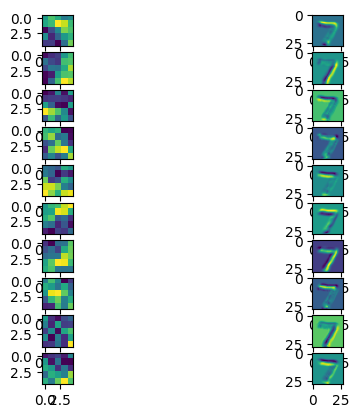

In [25]:
visualize()

In [26]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [27]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_26964/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [39]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [40]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_26964/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.332296
Train loss: 1.957535
Train loss: 1.462207
Train loss: 1.014435
Train loss: 0.627142
Train loss: 0.616435
Train loss: 0.475159
Train loss: 0.659763
Train loss: 0.616568
Train loss: 0.579007
Test accuracy: 94%

Train loss: 0.350473
Train loss: 0.504907
Train loss: 0.327363
Train loss: 0.426958
Train loss: 0.338403
Train loss: 0.271771
Train loss: 0.264161
Train loss: 0.390316
Train loss: 0.321871
Train loss: 0.436253
Test accuracy: 96%

Train loss: 0.291963
Train loss: 0.197421
Train loss: 0.202241
Train loss: 0.391304
Train loss: 0.176931
Train loss: 0.349548
Train loss: 0.294814
Train loss: 0.411946
Train loss: 0.413940
Train loss: 0.458518
Test accuracy: 97%

Train loss: 0.264083
Train loss: 0.289836
Train loss: 0.249974
Train loss: 0.297781
Train loss: 0.210276
Train loss: 0.229125
Train loss: 0.310620
Train loss: 0.242642
Train loss: 0.182461
Train loss: 0.219221
Test accuracy: 98%

Train loss: 0.216653
Train loss: 0.284743
Train loss: 0.188868
Train loss: 0.235

## Accuracy
600: Accuracy here is average(12 + 17 + 21 + 29 + 37) = 23.2%
3000: Accurary here is average(38 + 50 + 68 + 79 + 85) = 64%
6000: Accuracy here is average(54 + 74 + 83 + 88 + 90) = 77.8%
30,000: Accuracy here is average(93 + 95 + 95 + 96 + 96) = 95%
60,000: Accuracy here is average(93 + 96 + 95 +  97 + 97) = 95.75%

## Weights
Weights in the 600 image training set looks completely random and not weighted at all, no visible clustering. This is unlike the 60,000, where you can see clustering within the visualization indicating that there are areas being weighted. 

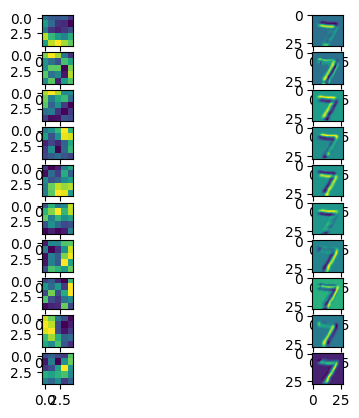

In [41]:
visualize()

## Weights